# 02c - Vertex AI > Pipelines - AutoML with clients (code) In automated pipeline

Use[ Kubeflow](https://www.kubeflow.org/) Pipelines running on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to orchestrate the process of training a custom model with AutoML Tabular and deploy it to a Vertex AI Endpoint for serving (online and batch) predictions and explanations.  This demonstrates how to automate the processes of (02a) or (02b) with pipeline orchestration.

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:
<p><center><a href="https://youtu.be/1gHJgY7AXAs" target="_blank" rel="noopener noreferrer"><img src="architectures/thumbnails/playbutton/02c.png" width="50%"></a></center></p>

### Prerequisites:
-  01 -  BigQuery - Table Data Source

### Overview:
-  Use Kubeflow Python SDK to build a pipeline
   -  Create pipeline using Google Cloud Pipeline Components (from google_cloud_pipeline_components import aiplatform as gcc_aip)
      -  Use cc_aip.TabularDatasetCreateOp to register dataset from BigQuery table
      -  Train AutoML tabular model with gcc_aip.AutoMLTabularTrainingJobRunOp
      -  Deploy model to endpoint using gcc_aip.ModelDeployOp
   -  Compile the pipeline
      -  kfp.v2.compiler.Compiler().compile
   -  Move the pipeline code to GCS Bucket
   -  Run the pipeline with google.cloud.aiplatform.PipelineJob
-  Online Predictions using Vertex AI Endpoint
-  Online Explanations using Vertex AI Endpoint
-  Batch Prediction Job for predictions and explanation with source and destination tables in BigQuery

### Resources:
-  [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline#google-cloud-components) see aiplatform.PipelineJob
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [Kubeflow Pipelines Components for Google Cloud](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud)

### Related Training:
-  Codelab: [Vertex AI Pipelines Introduction](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0)
-  todo

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/02c_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/02c_console.png">

---
## Setup

inputs:

In [44]:
REGION = 'us-central1'
PROJECT_ID='ma-mx-presales-lab'
DATANAME = 'fraud'
NOTEBOOK = '02c'
LABEL = 'label2c'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [45]:
from google.cloud import aiplatform
from datetime import datetime
import kfp
#import kfp.v2.dsl as dsl

from google_cloud_pipeline_components import aiplatform as gcc_aip

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [46]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [47]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
#BUCKET = PROJECT_ID
BUCKET = "vertex-ai-mlops-bucket"
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [48]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'825075454589-compute@developer.gserviceaccount.com'

environment:

In [49]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

In [50]:
@kfp.dsl.pipeline(name = f'kfp-{NOTEBOOK}-{DATANAME}-{TIMESTAMP}', pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/')
def pipeline(
    project: str = PROJECT_ID,
    dataname: str = DATANAME,
    display_name: str = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    deploy_machine: str = DEPLOY_COMPUTE,
    bq_source: str = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    var_target: str = VAR_TARGET,
    var_omit: str = VAR_OMIT #,
    #label: str = NOTEBOOK 
    #label: str = LABEL
):
    
    # dataset
    dataset = gcc_aip.TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source #,
        #labels = {'notebook':f'{label}}'                 
    )
    
    # get feature names
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = PROJECT_ID)
    query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
    schema = bigquery.query(query).to_dataframe()
    OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
    features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
    features = dict.fromkeys(features, 'auto')
    
    # training
    model = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "maximize-au-prc",
        budget_milli_node_hours = 1000,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],   # Passing values between components
        target_column = var_target,
        predefined_split_column_name = 'splits' #,
        #labels = {'notebook':f'{label}'}
    )
    
    # Endpoint: Creation
    endpoint = gcc_aip.EndpointCreateOp(
        project = project,
        display_name = display_name #,
        #labels = {'notebook':f'{label}'}
    )
    
    # Endpoint: Deployment of Model
    deployment = gcc_aip.ModelDeployOp(
        model = model.outputs["model"],     # Passing values between components
        endpoint = endpoint.outputs["endpoint"],    # Passing values between components
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )

---
## Compile Pipeline

In [51]:
kfp.v2.compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [52]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/02c/02c.json [Content-Type=application/json]...
/ [1 files][ 23.3 KiB/ 23.3 KiB]                                                
Operation completed over 1 objects/23.3 KiB.                                     


---
## Create Vertex AI Pipeline Job

In [53]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    template_path = f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json",
    pipeline_root = f"{URI}/{TIMESTAMP}/kfp/",
    #labels = {'notebook':f'{LABEL}'}
)

In [54]:
response = pipeline.run(service_account = SERVICE_ACCOUNT)

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/825075454589/locations/us-central1/pipelineJobs/kfp-02c-fraud-20220329212155-20220329212200
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/825075454589/locations/us-central1/pipelineJobs/kfp-02c-fraud-20220329212155-20220329212200')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-02c-fraud-20220329212155-20220329212200?project=825075454589
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/825075454589/locations/us-central1/pipelineJobs/kfp-02c-fraud-20220329212155-20220329212200 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/8

In [55]:
aiplatform.get_pipeline_df(pipeline = f'kfp-{NOTEBOOK}-{DATANAME}-{TIMESTAMP}')

,pipeline_name,run_name,param.input:dataname,param.input:var_omit,param.input:display_name,param.input:var_target,param.input:bq_source,param.input:project,param.input:deploy_machine
0,kfp-02c-fraud-20220329212155,kfp-02c-fraud-20220329212155-20220329212200,fraud,transaction_id,02c_fraud_20220329212155,Class,bq://ma-mx-presales-lab.fraud.fraud_prepped,ma-mx-presales-lab,n1-standard-4


---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

<p><center><a href="https://youtu.be/m_x3WBtr6y0" target="_blank" rel="noopener noreferrer"><img src="architectures/thumbnails/playbutton/02c.png" width="50%"></a></center></p>
<p><center>Part 2 Video</center></p>

For more information review [this page](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models).

Get the Model:

In [56]:
model = aiplatform.Model.list(filter=f'display_name={NOTEBOOK}_{DATANAME}_{TIMESTAMP}')

Setup a model client for the model create by this notebook:

In [57]:
model[0].resource_name

'projects/825075454589/locations/us-central1/models/53080023342514176'

In [58]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [63]:
#model = model[0]
evaluations = model_client.list_model_evaluations(parent = model[0].resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [64]:
geteval.metrics['auPrc']

0.99972355

In [65]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28423.0, 2.0]
True Label =  1  has Predicted labels =  [10.0, 33.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [66]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [67]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.99978846
Label =  1 has auPrc =  0.8341116


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [68]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [69]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,6126,-0.130702,1.026568,2.692793,2.659141,0.764928,1.800330,0.317986,-0.392976,0.851460,...,-0.370958,-1.058635,-0.498915,0.054906,-0.590204,-0.537678,0.0,0,70526fff-bdf3-459f-bbc6-a18e8133bb35,TEST
1,32799,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e8b3c609-62a9-4ec3-9ff8-fd0974b07602,TEST
2,35599,1.168909,-0.139981,-0.095518,1.735426,1.699903,4.646212,-1.191502,1.205700,0.333882,...,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0,c5ac2c63-c26b-492e-bc8e-5f98e92ec866,TEST
3,49561,1.333331,-0.845997,1.161578,-0.610965,-1.635783,-0.198304,-1.331531,0.212857,-0.208834,...,-0.095332,0.367347,0.398274,-0.059810,0.041674,0.011653,0.0,0,aca44b9b-e816-4767-b636-0356637c286b,TEST


In [70]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [71]:
newob['Time'] = str(newob['Time'])

In [72]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [73]:
aiplatform.Endpoint.list(filter=f'display_name={NOTEBOOK}_{DATANAME}_{TIMESTAMP}')

 resource name: projects/825075454589/locations/us-central1/endpoints/6826234378163585024]

In [74]:
endpoint = aiplatform.Endpoint.list(filter=f'display_name={NOTEBOOK}_{DATANAME}_{TIMESTAMP}')[0]
endpoint.display_name

'02c_fraud_20220329212155'

In [75]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'scores': [0.9997609257698059, 0.0002390758891124278], 'classes': ['0', '1']}], deployed_model_id='6625876971303731200', explanations=None)

In [76]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [77]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [78]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "classes": [
        "0",
        "1"
      ],
      "scores": [
        0.99976092576980591,
        0.0002390758891124278
      ]
    }
  ],
  "deployedModelId": "6625876971303731200",
  "model": "projects/825075454589/locations/us-central1/models/53080023342514176",
  "modelDisplayName": "02c_fraud_20220329212155"
}


### Get Predictions: gcloud (CLI)

In [79]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9997609257698059, 0.0002390758891124278]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [80]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [81]:
explanation.predictions

[{'classes': ['0', '1'],
  'scores': [0.9997609257698059, 0.0002390758891124278]}]

In [82]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9999701380729675
instance output 0.9997609257698059
output_index [0]
output display value 0
approximation error 0.016063349050327018


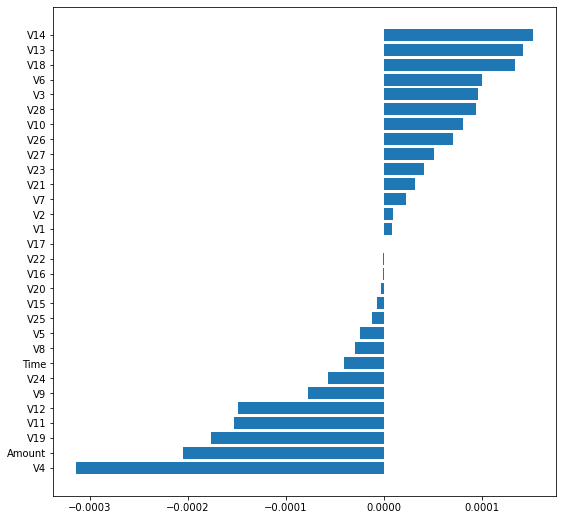

In [83]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [84]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/825075454589/locations/us-central1/batchPredictionJobs/8196309979012005888
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/825075454589/locations/us-central1/batchPredictionJobs/8196309979012005888')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/8196309979012005888?project=825075454589
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/825075454589/locations/us-central1/batchPredictionJobs/8196309979012005888 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/825075454589/locations/us-central1/batchPredictionJobs/8196309979012005888 current state:
JobState.JOB_STAT

KeyboardInterrupt: 

---
## Remove Resources
see notebook "99 - Cleanup"